In [ ]:
!pip install image_tabular

In [ ]:
!unzip Dataset.zip

Archive:  Dataset.zip
  inflating: sample_output.txt       
  inflating: Train_data.csv          
   creating: __MACOSX/
  inflating: __MACOSX/._Train_data.csv  
  inflating: Test_Data.csv           
  inflating: __MACOSX/._Test_Data.csv  


In [1]:
from fastai.vision import *
from fastai.tabular import *
from image_tabular.core import *
from image_tabular.dataset import *
from image_tabular.model import *
from image_tabular.metric import *

# use gpu by default if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [3]:
data_path = Path("./")

In [4]:
train_df = pd.read_csv(data_path/"Train_data.csv")
test_df = pd.read_csv(data_path/"Test_Data.csv")

print(len(train_df), len(test_df))

60326 3000


In [5]:
train_df.head(10)

,Unnamed: 0,code,clientType,registrationMode,planName,accident,duration,country,netSales,netProfit,gender,age
0,1,CBH,Basic,Offline,M,0,186,MALAYSIA,-29.0,9.57,F,81
1,2,CBH,Basic,Offline,M,0,186,MALAYSIA,-29.0,9.57,F,71
2,3,CWT,Basic,Online,Q,0,65,AUSTRALIA,-49.5,29.70,NaN,32
3,4,CWT,Basic,Online,Q,0,60,AUSTRALIA,-39.6,23.76,NaN,32
4,5,CWT,Basic,Online,Q,0,79,ITALY,-19.8,11.88,NaN,41
5,6,JZI,Premium,Online,Z,0,66,UNITED STATES,-121.0,42.35,F,44
6,7,CWT,Basic,Online,Q,0,63,AUSTRALIA,-108.9,65.34,NaN,29
7,8,CWT,Basic,Online,Q,0,57,THAILAND,-19.8,11.88,NaN,44
8,9,CWT,Basic,Online,Q,0,186,AUSTRALIA,-99.0,59.40,NaN,37
9,10,JZI,Premium,Online,I,0,33,"KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF",-26.0,9.10,NaN,118


In [6]:
# extremely unbalanced dataset, most of the images are benign
train_df["accident"].value_counts(normalize=True)

0    0.985413
1    0.014587
Name: accident, dtype: float64

## Tabular data

In [7]:
# idx for validation
val_idx = get_valid_index(train_df)
len(val_idx)

12065

In [8]:
dep_var = 'accident'
cat_names = ['code','gender', 'country', 'planName']
# cat_names = ['gender']
cont_names = ['age']
procs = [FillMissing, Categorify, Normalize]
bs=256

In [9]:
test_data = TabularList.from_df(test_df, path=data_path,
                                cat_names=cat_names, cont_names=cont_names)

tab_data = (TabularList.from_df(train_df, path=data_path, cat_names=cat_names,
                                cont_names=cont_names, procs=procs)
            .split_by_idx(val_idx)
            .label_from_df(cols=dep_var)
            .add_test(test_data)
            .databunch(bs=bs))

In [10]:
# examples
tab_data.show_batch(rows=10)

code,gender,country,planName,age,target
EPX,#na#,UNITED STATES,K,0.3587,0
EPX,#na#,SRI LANKA,K,-0.2822,0
C2B,F,SINGAPORE,J,-0.4958,0
EPX,#na#,HONG KONG,A,-0.3534,0
EPX,#na#,UNITED STATES,K,-0.1398,0
C2B,M,SINGAPORE,J,-0.4958,0
CWT,#na#,MALAYSIA,Q,-0.6382,0
EPX,#na#,UNITED STATES,K,-1.1367,0
EPX,#na#,INDONESIA,K,-0.9943,0
EPX,#na#,THAILAND,K,-0.2822,0


In [11]:
# adjust loss function weight because the dataset is extremely unbalanced
weights = [1/(1-train_df["accident"].mean()), 1/train_df["accident"].mean()]
loss_func = CrossEntropyFlat(weight=torch.FloatTensor(weights).to(device))

In [12]:
# package everything in a fastai learner, add auc roc score as a metric
learn = tabular_learner(tab_data, layers=[8,8], metrics=[accuracy, ROCAUC()],
                        loss_func=loss_func)

## Training

epoch,train_loss,valid_loss,accuracy,rocauc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-01
Min loss divided by 10: 4.37E-02


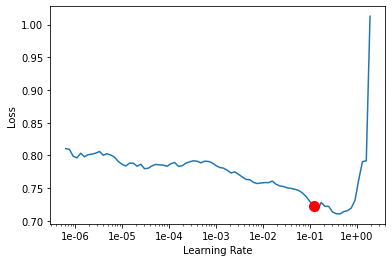

In [13]:
# find learning rate
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [14]:
# train
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,rocauc,time
0,0.602822,0.548635,0.676585,0.807680,00:03
1,0.548290,0.529555,0.858102,0.823062,00:03
2,0.538009,0.537331,0.851969,0.821405,00:02
3,0.520819,0.528970,0.690261,0.815370,00:03
4,0.515886,0.506564,0.835143,0.830045,00:03
5,0.505582,0.530115,0.804890,0.823252,00:03
6,0.495530,0.514460,0.785993,0.826967,00:03
7,0.503582,0.515510,0.800000,0.825188,00:03
8,0.501165,0.514870,0.816908,0.826536,00:02
9,0.487414,0.515831,0.813676,0.826260,00:02


## Prediction

In [15]:
# make predictions for the test set
preds, y = learn.get_preds(DatasetType.Test)

In [16]:
preds[:, 1]
ans = preds[:, 1].tolist()
ans

[0.20983624458312988,
 0.07868248969316483,
 0.19388632476329803,
 0.09841718524694443,
 0.23378333449363708,
 0.46881285309791565,
 0.32590553164482117,
 0.22468189895153046,
 0.7835299968719482,
 0.11730463802814484,
 0.7789034843444824,
 0.07732235640287399,
 0.7696294784545898,
 0.20983624458312988,
 0.32178324460983276,
 0.2096312791109085,
 0.10458734631538391,
 0.024053210392594337,
 0.09817106276750565,
 0.09170424193143845,
 0.3019355833530426,
 0.3376294672489166,
 0.3717038035392761,
 0.10799900442361832,
 0.21701936423778534,
 0.04843715578317642,
 0.11936637759208679,
 0.21701936423778534,
 0.13528132438659668,
 0.5561032891273499,
 0.39932480454444885,
 0.31710296869277954,
 0.4724617302417755,
 0.28056731820106506,
 0.4724617302417755,
 0.05240805819630623,
 0.5663434267044067,
 0.6570279002189636,
 0.11263369023799896,
 0.8609780073165894,
 0.2946864664554596,
 0.10809226334095001,
 0.76392662525177,
 0.2349623441696167,
 0.16857974231243134,
 0.09719819575548172,
 0.09

In [37]:
with open('output_16b_1e-4.txt', 'w') as f:
    for item in ans:
        f.write("%0.6f\n" % item)